In [21]:
import math
import json
import os
import random
from IPython import display
import sympy as sp
import numpy as np
import pandas as pd
import sklearn

pd.set_option('display.max_rows', None)


%run config.py

Utility functions

In [22]:
# Colors for terminal output
GREEN = "\033[92m"
RED = "\033[91m"
YELLOW = "\033[93m"
BLUE = "\033[94m"
CYAN = "\033[96m"
MAGENTA = "\033[95m"
BOLD = "\033[1m"
UNDERLINE = "\033[4m"
STANDARD = "\033[0m"

In [23]:
# Sequencer and Desequencer
def csv2sequence(csvFile,seqFile,pref):
	with open(csvFile, 'r') as f:
		lines = f.readlines()
		with open(seqFile, 'w') as g:
			for line in lines:
				for token in line.split(','):
					if token.startswith(pref):
						token = token[len(pref):]
					token = token.strip()
					if token!="" and token!='\n':
						g.write(token+'\n')

def sequence2csv(seqFile,csvFile,dataWidth,pref):
	with open(seqFile, 'r') as f:
		lines = f.readlines()
		dataW = dataWidth
		with open(csvFile, 'w') as g:
			for line in lines:
				g.write(pref+line.strip())
				dataW -= 1
				if dataW==0:
					g.write('\n')
					dataW = dataWidth
				else:
					g.write(',')

In [24]:
# Function to show the generated function
def showFunction():
	exec(open("generated.py").read())
	import IPython.display as disp
	disp.display(spExpr)
# showFunction()

In [25]:
# Function to show the generated BM
def showBM():
	display.Image("bondmachine.png")

In [26]:
def highlightDone(val):
    color = 'green' if val > 0.0 else 'red'
    return f'background-color: {color}'

environment creation functions

In [27]:
# Function create an environment with a random mathematical expression
def generateRandom():
	! echo "SOURCE_FLEXPY=generated.py" > source.mk
	! make clean > /dev/null
	! echo "SOURCE_FLEXPY=generated.py" > source.mk
	! flexpytester --generate -e symbols -s generated.py -i inputs.csv -o outputs.csv --prefix --config decayFactor=3 > /dev/null
	! bmhelper apply > /dev/null 
	! make show > /dev/null
	csv2sequence('inputs.csv','inputs.seq',"0f")
	csv2sequence('outputs.csv','outputs.seq',"0f")
# generateRandom()

In [28]:
# Function to generate the test cases of an existing mathematical expression
def generateExistent():
	! echo "SOURCE_FLEXPY=generated.py" > source.mk
	! make clean > /dev/null
	! echo "SOURCE_FLEXPY=generated.py" > source.mk
	! flexpytester --compute -e generated.py -i inputs.csv -o outputs.csv --prefix > /dev/null
	! bmhelper apply > /dev/null 
	! make show > /dev/null
	csv2sequence('inputs.csv','inputs.seq',"0f")
	csv2sequence('outputs.csv','outputs.seq',"0f")
# generateExistent()

In [29]:
# Function to generate the test cases of an existing single neuron within the library
def generateNeuron(library, neuron, seq):
	! echo "SOURCE_BASM=out.basm" > source.mk
	! make clean > /dev/null
	! echo "SOURCE_BASM=out.basm" > source.mk
	! rm -f notok
	! fragtester -neuron-lib-path {library} -fragment-file {neuron}.basm -save-expression generated.py -seq {seq} -create-bmapi bmapi.json -build-app -app-flavor cpynqapi -app-file expression.c || touch notok > /dev/null
	if os.path.exists("notok"):
		return False
	! flexpytester --compute -e generated.py -i inputs.csv -o outputs.csv --prefix > /dev/null
	! bmhelper apply > /dev/null
	! make show > /dev/null
	csv2sequence('inputs.csv','inputs.seq',"0f")
	csv2sequence('outputs.csv','outputs.seq',"0f")
	return True
# generateNeuron("library", "cosargreal", "0")

In [30]:
# Function to generate the test cases of an existing single neuron within the library
def getNeuronSeq(library, neuron):
	! rm -f notok
	! fragtester -neuron-lib-path {library} -fragment-file {neuron}.basm -save-expression generated.py  || touch notok > /dev/null
	if os.path.exists("notok"):
		return "0"
	! fragtester -neuron-lib-path {library} -fragment-file {neuron}.basm -save-expression generated.py -describe | grep "Sequences" | cut -d' ' -f2 > seqs.txt
	seq=1
	with open("seqs.txt", "r") as f:
		lines = f.readlines()
		for line in lines:
			seq=line.strip()
			return seq

In [31]:
# Function to generate the test cases of an existing single neuron within the library
def placeHolderNeuron(library, neuron):
	! echo "{" > statistics.json
	! echo -n "\"" >> statistics.json
	! echo -n {neuron} >> statistics.json
	! echo "\": 0" >> statistics.json
	! echo "}" >> statistics.json

 Simulation beckends

In [32]:
# BondMachine internal simulator
def runSimbatch():
	! make simbatch > /dev/null
# runSimbatch()

In [33]:
# BondMachine hardware run
def runBMsim():
	! make deploycollect > /dev/null
	! mv working_dir/bmsim_outputs.seq bmsim_outputs.seq
	! bondmachine -bondmachine-file working_dir/bondmachine.json -list-outputs | wc -l > num_outputs.txt
	# Read the number of outputs
	with open('num_outputs.txt','r') as f:
		num_outputs = int(f.read())
	sequence2csv('bmsim_outputs.seq','bmsim_outputs.csv',num_outputs,"")
# runBMsim()

In [34]:
# HLS simulator
def rubHLSsim():
	print ("hlsim")
# runHLSsim()

Analysis

In [35]:
def analyzeSimbatch():
	# Load the target outputs from the output.csv file
	targetData = np.loadtxt('outputs.csv', delimiter=',')
	simbatchData = np.loadtxt('simbatch_outputs.csv', delimiter=',')
	simbatchMSE=sklearn.metrics.mean_squared_error(targetData, simbatchData)

	data = {
		"Dataset": ["Sympy target", "Simbatch"],
		"MSE" : [0.0, simbatchMSE]
	}
	df = pd.DataFrame(data)
	return df.style.hide(axis="index"), simbatchMSE

	

Statistics management functions

In [36]:
def plotHistogram(df):
	# Plot the histogram
	df['occurrences'].plot(kind='bar', figsize=(10, 6), color='skyblue')


In [37]:
def loadRun(mse):
	with open('statistics.json', 'r') as f:
		data = json.load(f)
	
	df = pd.DataFrame.from_dict(data, orient='index', columns=['occurrences'])
	totOccurrences = df['occurrences'].sum()
	newCol=mse
	if totOccurrences > 0:
		newCol = newCol/totOccurrences
		df['error'] = newCol
	else:
		df['error'] = 0.0
	return df

In [38]:
def PatchGlobalStats(global_stats, df):
	# If the global statistics DataFrame is empty, initialize it with the same rows as the current DataFrame
	for index, row in df.iterrows():
		if index not in global_stats.index:
			global_stats.loc[index] = [0.0, 0.0]

	# Sum the occurrences to the global statistics
	for index, row in df.iterrows():
		global_stats.at[index, 'occurrences'] += row['occurrences']
		global_stats.at[index, 'error'] += row['error']
	# Save the updated global statistics
	global_stats.to_csv('global_statistics')
	return global_stats


In [39]:
def loadGlobalStats():
	# Load the global statistics from the CSV file if it exists
	if os.path.exists('global_statistics'):
		global_stats = pd.read_csv('global_statistics', index_col=0)
		global_stats.sort_index(inplace=True)
	else:
		# Create an empty DataFrame with the same columns as the global statistics
		global_stats = pd.DataFrame(columns=['occurrences', 'error'])
	return global_stats

Interactive sessions

In [40]:
# Single run test, it executes the entire process and return a DataFrame (df) with the errors
if singleRun:	
	# generateRandom()
	# generateExistent()
	generateNeuron("library", "multargrealnumreal", "0")
	runSimbatch()
	runBMsim()
	# runHLSsim()
	errors,mse=analyzeSimbatch()
	# errors
	df=loadRun(mse)

ls: cannot access '*.vhd': No such file or directory


In [41]:
df if singleRun else None

,occurrences,error
multargrealnumreal,1,0.0


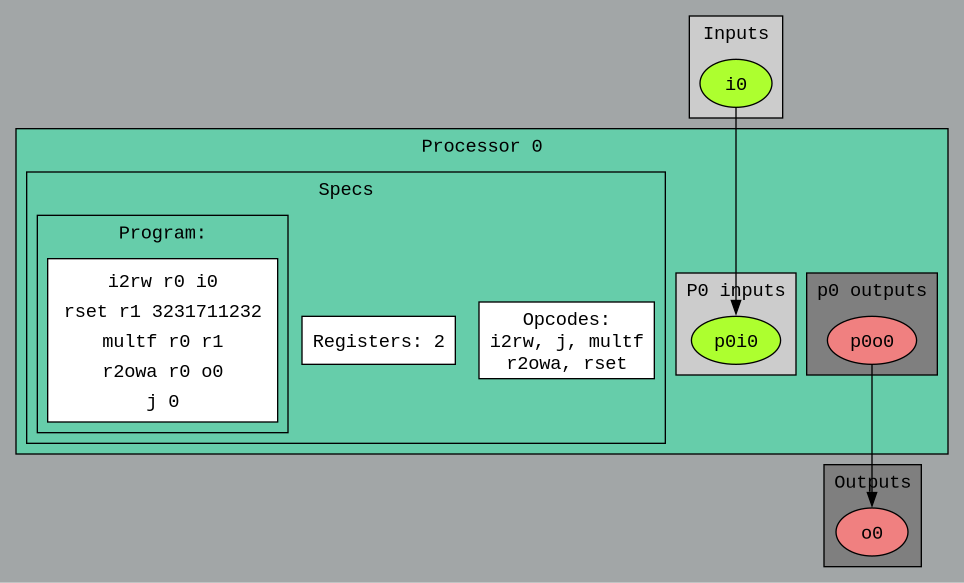

In [42]:
display.Image("bondmachine.png") if singleRun else None

In [43]:
# Load the historical global statistics and patch it with the new data (df)
if singleRunPatch:
	gs=loadGlobalStats()
	gs=PatchGlobalStats(gs, df)
	gs

In [44]:
gs if singleRunPatch else None

In [45]:
if fullRun:
	# Iterate al the neurons in the library and test them singly, patching the global statistics
	gs=loadGlobalStats()

	for neuronFile in os.listdir("library"):
		if not neuronFile.endswith(".basm"):
			continue
		neuron = neuronFile.split(".")[0]
		# generateRandom()
		# generateExistent()
		if any(gs.index.str.startswith(neuron)) and gs.loc[gs.index.str.startswith(neuron), 'occurrences'].max() > 0:
			continue
		seq=getNeuronSeq("library", neuron)
		if seq!="0":
			for i in range(0, int(seq)):
				if generateNeuron("library", neuron, str(i)):
					runSimbatch()
					# runBMsim()
					# runHLSsim()
					errors,mse=analyzeSimbatch()
					df=loadRun(mse)
					gs=PatchGlobalStats(gs, df)
				else:
					print(f"{RED}Error generating neuron {neuron} with sequence {seq}{STANDARD}")
		else:
			placeHolderNeuron("library", neuron)

			df=loadRun(0.0)
			gs=PatchGlobalStats(gs, df)

	gs.style.format('{:.10f}', subset=['error'])
	gs.style.apply(lambda x: x.map(highlightDone), axis=None, subset=['occurrences'])


In [46]:
gs.style.apply(lambda x: x.map(highlightDone), axis=None, subset=['occurrences']) if fullRun else None